In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import json
from environment import Environment
from logging_config import setup_logging
import logging
from utils import findUE, BPRCostFunction, findSO   
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science", "no-latex"])
import warnings

# Ignore this specific RuntimeWarning from PoA finder
warnings.filterwarnings(
    "ignore", 
    category=RuntimeWarning, 
    message="Values in x were outside bounds during a minimize step"
)


In [89]:
import pandas as pd
import random
import numpy as np

In [90]:
params = None
with open("params.json") as f:
    params = json.load(f)
if not params:
    raise Exception("No parameters found!")
env1 = Environment(params) # area with PoA ~1.1
params['env_params']['PoA'] = 1.3
env2 = Environment(params) # area with PoA ~1.3
envs = [env1,env2]

ACCIDENT: Env 1, Route 2, Day 220
 > Impacted Drivers: 56
 > Fleet Avg Time Change: +17.1592
 > Travel Time: 170.09 (vs 16.89)
ACCIDENT: Env 1, Route 0, Day 495
 > Impacted Drivers: 52
 > Fleet Avg Time Change: +17.1466
 > Travel Time: 183.36 (vs 18.49)


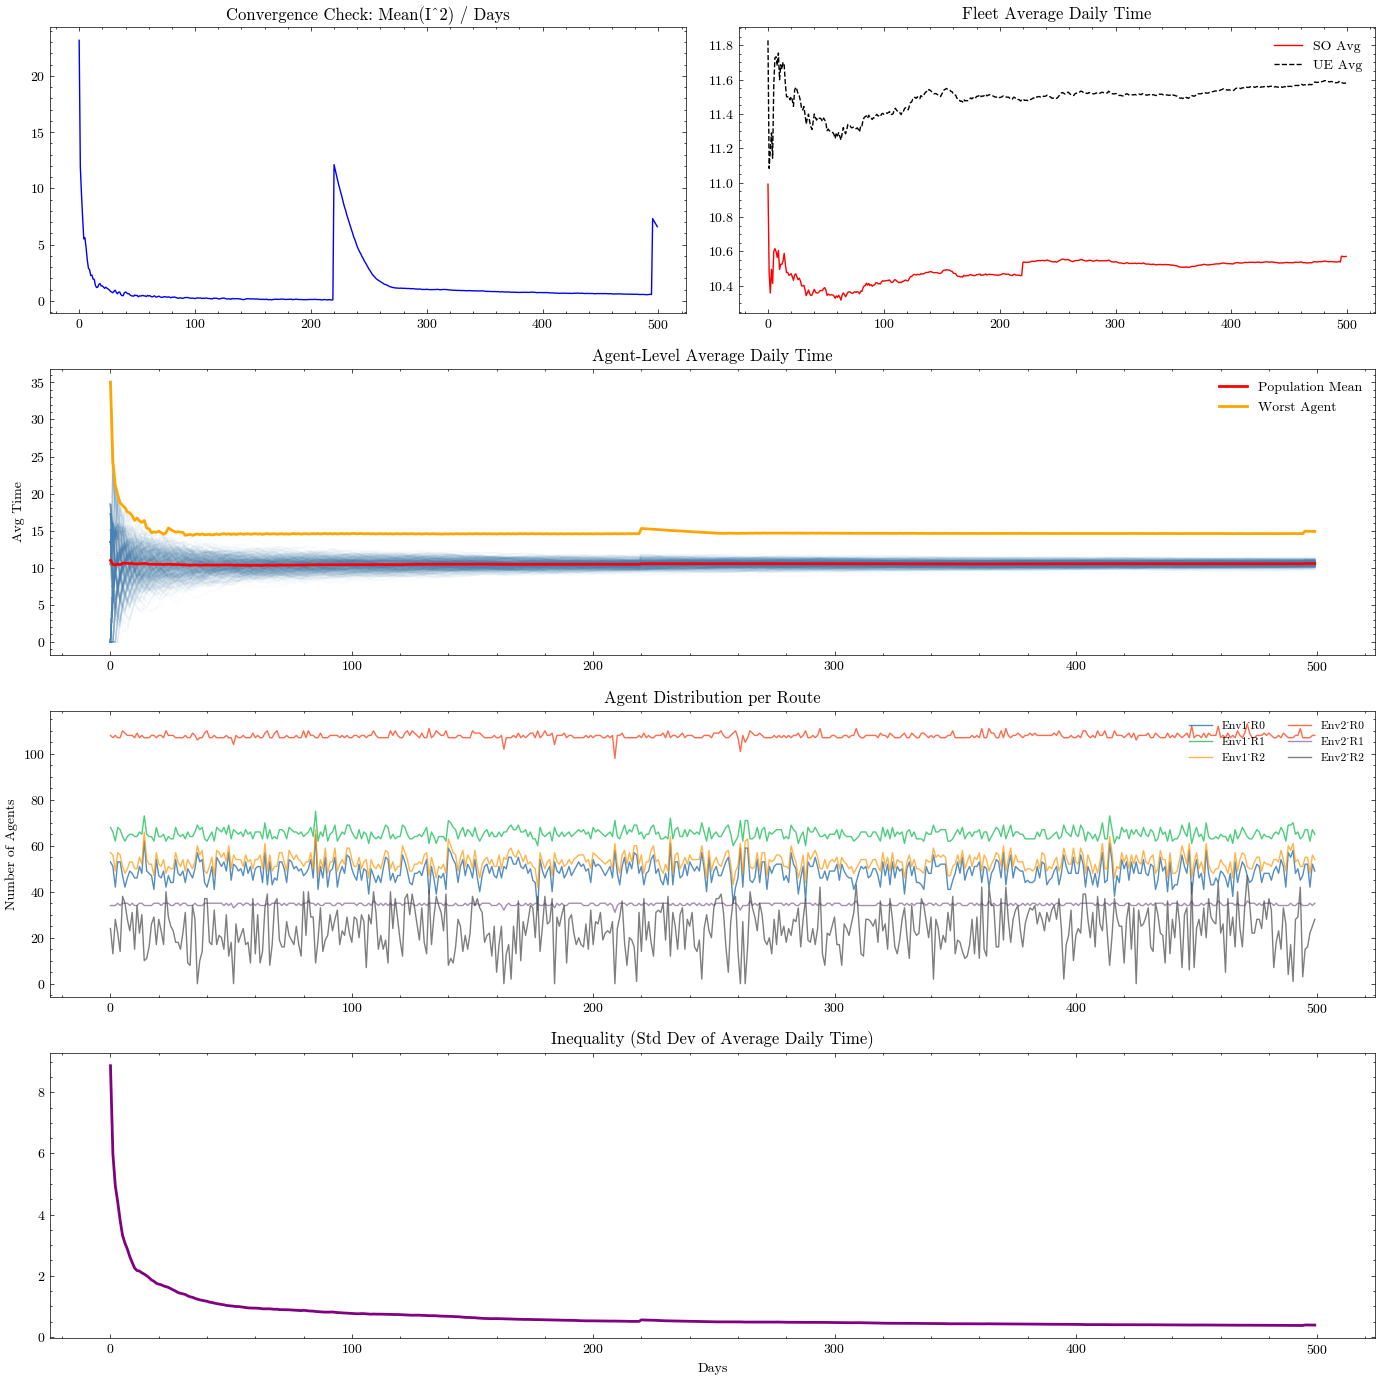

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Suppress SciPy clipping warnings globally
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Values in x were outside bounds")

# --- Initialization ---
Q = params["env_params"]["Q"]
choices = list(range(params["env_params"]["destinations"])) + [-1]
num_choices = len(choices)

df = pd.DataFrame(index=range(Q))
df["I"] = np.random.normal(0, 1e-12, size=len(df))
df["total_time_SO"] = 0.0
df["total_time_UE"] = 0.0

# Storage
history_avg_I_sq = [] 
history_avg_SO = []
history_avg_UE = []
history_worst_avg_SO = []
history_std_avg_SO = []
agent_trajectories = [] 
route_usage_history = [] # Tracks number of agents per route

def day(df, d, params):
    df["choice"] = np.random.choice(choices, size=len(df))
    if d < params["env_params"]["fresh_after"]:
        df["choice"] = df.apply(
            lambda x: x["choice"] if x.name > params["env_params"]["fresh_share"] else 0,
            axis=1,
        )

    df["t_today_SO"] = 0.0
    df["t_today_UE"] = 0.0
    daily_route_counts = {}

    for i, env in enumerate(envs):
        k = len(env.routes)
        mask = df["choice"] == i
        Q_env = mask.sum()
        if Q_env == 0: continue

        df.loc[mask, "I_rank"] = df.loc[mask, "I"].rank(ascending=False, method='first').astype(int)
        
        q_env = params["env_params"]["congestion"] * Q_env / (Q / num_choices)
        X_ue, _ = findUE(q_env, env.routes)
        tUE_val = env.routes[0](X_ue[0])
        
        X_so, T_so = findSO(q_env, env.routes)
        hat_T = T_so / q_env
        tSO_list = [env.routes[j](X_so[j]) for j in range(k)]
        
        # Realize travel times
        noise = np.random.normal(1, params["env_params"]["noise"], size=k)
        disruption_mask = np.random.choice([1, 10], p=[1 - params["env_params"]["p_disruption"], params["env_params"]["p_disruption"]], size=k)
        real_tSO = np.array(tSO_list) * noise * disruption_mask

        # Assignment
        route_order = np.array(tSO_list).argsort()
        exact_counts = (X_so[route_order] / X_so.sum()) * Q_env
        counts_per_route_rank = np.diff(np.round(np.cumsum(np.insert(exact_counts, 0, 0)))).astype(int)
        splits = np.cumsum(counts_per_route_rank)

        agent_ranks = df.loc[mask, "I_rank"].values - 1
        assigned_bins = np.searchsorted(splits, agent_ranks, side='right')
        assigned_bins = np.clip(assigned_bins, 0, k-1)
        
        df.loc[mask, "route"] = route_order[assigned_bins]
        
        # Track Route Usage
        for r_idx in range(k):
            n_on_route = (df.loc[mask, "route"] == r_idx).sum()
            daily_route_counts[f"Env{i+1}_R{r_idx}"] = n_on_route

            # Accident Impact Tracking
            if disruption_mask[r_idx] > 1:
                # Delta = (Real Time - Expected Time) * Drivers on that route / Total Q
                fleet_impact = ((real_tSO[r_idx] - tSO_list[r_idx]) * n_on_route) / Q
                print(f"ACCIDENT: Env {i+1}, Route {r_idx}, Day {d}")
                print(f" > Impacted Drivers: {n_on_route}")
                print(f" > Fleet Avg Time Change: +{fleet_impact:.4f}")
                print(f" > Travel Time: {real_tSO[r_idx]:.2f} (vs {tSO_list[r_idx]:.2f})")
        
        daily_time_map = {idx: real_tSO[idx] for idx in range(k)}
        inequity_map = {idx: (real_tSO[idx] - hat_T) for idx in range(k)}
        
        df.loc[mask, "t_today_SO"] = df.loc[mask, "route"].map(daily_time_map)
        df.loc[mask, "inequity_today"] = df.loc[mask, "route"].map(inequity_map)
        df.loc[mask, "t_today_UE"] = tUE_val
        df.loc[mask, "I"] += df.loc[mask, "inequity_today"]

    route_usage_history.append(daily_route_counts)
    df["total_time_SO"] += df["t_today_SO"]
    df["total_time_UE"] += df["t_today_UE"]
    return df

# --- Simulation Loop ---
total_days = params["env_params"]["days"]
for d in range(total_days):
    df = day(df, d, params)
    day_idx = d + 1
    current_avg_SO = df["total_time_SO"] / day_idx
    
    history_avg_I_sq.append(np.mean(df["I"]**2) / day_idx)
    history_avg_SO.append(current_avg_SO.mean())
    history_avg_UE.append((df["total_time_UE"] / day_idx).mean())
    history_worst_avg_SO.append(current_avg_SO.max())
    history_std_avg_SO.append(current_avg_SO.std())
    agent_trajectories.append(current_avg_SO.values.copy())

# --- Plotting ---
plt.figure(figsize=(14, 14))

# 1. Convergence & Fleet Performance
plt.subplot(4, 2, 1)
plt.plot(history_avg_I_sq, color='blue')
plt.title("Ineuquity Convergence (Avg I^2 / Days)")

plt.subplot(4, 2, 2)
plt.plot(history_avg_SO, label="SO Avg", color="red")
plt.plot(history_avg_UE, label="UE Avg", color="black", linestyle="--")
plt.title("Fleet Average Daily Time")
plt.legend()

# 2. Agent Trajectories (Average Daily Time)
plt.subplot(4, 1, 2)
plt.plot(np.array(agent_trajectories), color='steelblue', alpha=0.03) 
plt.plot(history_avg_SO, color='red', linewidth=2, label="Population Mean")
plt.plot(history_worst_avg_SO, color='orange', linewidth=2, label="Worst Agent")
plt.title("Agent-Level Average Daily Time")
plt.ylabel("Avg Time")
plt.legend()

# 3. Route Usage Tracking
plt.subplot(4, 1, 3)
usage_df = pd.DataFrame(route_usage_history)
for col in usage_df.columns:
    plt.plot(usage_df[col], label=col, alpha=0.7)
plt.title("Agent Distribution per Route")
plt.ylabel("Number of Agents")
plt.legend(loc='upper right', ncol=2, fontsize='small')

# 4. Inequality Measure
plt.subplot(4, 1, 4)
plt.plot(history_std_avg_SO, color="purple", linewidth=2)
plt.title("Std Dev of Average Daily Time")
plt.xlabel("Days")

plt.tight_layout()
plt.show()